# 🤖 Supervised Learning for Oil Well Fault Detection

## What is Supervised Classification?

Supervised learning uses labeled training data to predict categories for new data.

**Key Components:**
- **Training Data**: Examples with known answers (features + labels)
- **Features**: Sensor measurements (input)
- **Labels**: Fault types 0-9 (output)
- **Model**: Algorithm that learns patterns
- **Evaluation**: How well the model performs

## Our Problem: 3W Oil Well Classification

**Goal**: Predict oil well fault types from sensor data

**Input**: Time series from sensors (P-PDG, P-TPT, T-TPT)
**Output**: Fault classes (0=normal, 1-9=different faults)
**Challenge**: Multiple classes, imbalanced data, high dimensions

In [1]:
# ============================================================
# LOAD 3W DATASET
# ============================================================

import sys
import numpy as np

# Add src directory to path
sys.path.append("src")
from src import config
from src.supervised_classification import load_3w_data, print_neural_network_architectures

# Load dataset using utility function
(train_dfs, train_classes, train_fold_info,
 test_dfs, test_classes, test_fold_info) = load_3w_data(config, verbose=True)

Loading 3W Dataset for Classification
Found 3 folds
✅ Data loaded successfully!
   Training windows: 197259
   Test windows: 30177
   Window shape: (300, 4)


## Data Loading for Supervised Learning

**Key requirements:**
- **Labeled data** - Examples with known fault classifications
- **Train/test split** - Separate data for training and unbiased evaluation
- **Cross-validation** - Multiple data splits for robust performance estimates

**3W Dataset structure:**
- **Training data** - Used to teach algorithms to recognize patterns
- **Test data** - Unseen data to evaluate real-world performance
- **Windowed format** - Time series converted to fixed-size sequences
- **Class labels** - Fault types (0=normal, 1-8=different fault conditions)

# 📊 Classification Configuration

## Class Selection

Choose which fault types to analyze:

```python
selected_classes = [3, 4, 8]  # Focus on specific faults
selected_classes = [1, 2, 3, 4, 5]  # Early fault types  
selected_classes = None  # All fault types (exclude normal operation)
```

## Key Features

1. **Configurable Classes**: Select specific fault types for focused analysis
2. **Cross-Fold Validation**: Test model consistency across data splits  
3. **Class Balancing**: Handle imbalanced data with augmentation
4. **Multiple Algorithms**: Compare different ML approaches
5. **Performance Analysis**: Detailed metrics and visualizations

In [ ]:
# ============================================================
# CONFIGURE CLASSIFICATION
# ============================================================

from src.supervised_classification import validate_configuration

# Configuration
selected_classes = [3, 4, 8]  # Choose fault types to analyze
balance_test = False  # Keep original test distribution
min_test_samples_per_class = 300

print("Classification Configuration:")
print("=" * 35)

# Verify data availability
if not (train_dfs and test_dfs):
    print("❌ No data available. Run the data loading cell first.")
else:
    print(f"✅ Data ready: {len(train_dfs)} train, {len(test_dfs)} test windows")
    
    # Validate configuration
    config_valid = validate_configuration(selected_classes, test_classes, verbose=True)
    
    # Check fold information
    fold_available = (test_fold_info is not None and len(test_fold_info) == len(test_dfs))
    if fold_available:
        unique_folds = sorted(set(test_fold_info))
        print(f"✅ Fold information: {len(unique_folds)} folds detected")
    else:
        print("⚠️ No fold information available")

Classification Configuration:
✅ Data ready: 197259 train, 30177 test windows
Selected classes: [3, 5, 8]
✅ Fold information: 3 folds detected


## Multi-Algorithm Training Strategy

**Why compare multiple algorithms?**
- **No free lunch theorem** - No single algorithm works best for all problems
- **Data characteristics** - Different algorithms suit different data patterns
- **Performance trade-offs** - Speed vs accuracy vs interpretability

**Algorithm categories:**
- **Tree-based** - can be (depends on the algoritm and application): Interpretable, handle non-linear patterns , robust to outliers
- **Support Vector Machines** - Effective for high-dimensional data, kernel flexibility
- **Neural Networks** - Can learn complex patterns, require more data and tuning

**Evaluation strategy:**
- **Cross-validation** - Test on multiple data splits for robust estimates
- **Multiple metrics** - Accuracy, precision, recall, F1-score
- **Computational efficiency** - Training time and memory usage

## Cross-Validation Analysis

**Why cross-validation?**
- **Robust estimates** - Average performance across multiple data splits
- **Variance assessment** - How consistent is model performance?
- **Model stability** - Does performance vary significantly between folds?

**Interpreting fold results:**
- **Low variance** - Consistent performance across folds (good)
- **High variance** - Unstable performance (concerning)
- **Consistent ranking** - Same algorithms perform best across folds
- **Fold-specific patterns** - Some data splits may be more challenging

In [3]:
# ============================================================
# TRAIN CLASSIFICATION MODELS
# ============================================================

from src.supervised_classification import enhanced_fold_analysis
from tqdm import tqdm

if not (train_dfs and test_dfs):
    print("❌ No data available for training")
    supervised_classifier = None
else:
    print("🚀 Training Classification Models")
    print("=" * 40)
    
    models_to_train = ["Decision Tree", "Random Forest", "Linear SVM", "RBF SVM", 
                      "Simple Neural Network", "Deep Neural Network", "Regularized Neural Network"]
    
    print(f"Training {len(models_to_train)} algorithms...")
    
    # Train models with progress bar
    with tqdm(total=len(models_to_train), desc="Training", unit="model") as pbar:
        try:
            classifier = enhanced_fold_analysis(
                train_dfs=train_dfs,
                train_classes=train_classes,
                test_dfs=test_dfs,
                test_classes=test_classes,
                train_fold_info=(train_fold_info if fold_available else None),
                test_fold_info=(test_fold_info if fold_available else None),
                balance_classes=True,
                balance_strategy="combined",
                max_samples_per_class=1000,
                balance_test=balance_test,
                min_test_samples_per_class=min_test_samples_per_class,
                selected_classes=selected_classes,
                verbose=False,
            )
            pbar.update(len(models_to_train))
            supervised_classifier = classifier
            print("✅ Training completed successfully!")
            
        except Exception as e:
            print(f"❌ Training failed: {e}")
            supervised_classifier = None

🚀 Training Classification Models
Training 7 algorithms...


Training:   0%|          | 0/7 [00:00<?, ?model/s]

Preparing Data for Supervised Classification
Processing class labels... Training class distribution: {np.int64(3): np.int64(6028), np.int64(5): np.int64(16861), np.int64(8): np.int64(4414)}
Test class distribution: {np.int64(3): np.int64(242), np.int64(5): np.int64(265), np.int64(8): np.int64(550)}
⚖️ Class Balancing Strategy: combined
   • Original class distribution: {np.int16(3): 6028, 5: 16861, 8: 4414}
   • Original class distribution: {np.int16(3): 6028, 5: 16861, 8: 4414}
📉 Random Undersampling (strategy: auto)
   • Target class counts: {np.int16(3): 6028, 5: 6028, 8: 6028}
   • Final class distribution: {np.int16(3): 6028, np.int16(5): 6028, 8: 4414}
   • Samples: 27303 → 16470
📈 Random Oversampling (strategy: auto)
   • Original class distribution: {np.int16(3): 6028, np.int16(5): 6028, 8: 4414}
   • Target class counts: {np.int16(3): 6028, 5: 6028, 8: 6028}
   • Final class distribution: {np.int16(3): 6028, np.int16(5): 6028, 8: 6028}
   • Samples: 16470 → 18084


Training: 100%|██████████| 7/7 [00:46<00:00,  6.66s/model]

Complete Model Performance Comparison:
Model                     Train Acc    Test Acc     Train Time   Overfitting 
--------------------------------------------------------------------------------
Decision Tree             0.969        0.431        1.257        0.538       
Random Forest             0.984        0.623        0.400        0.361       
Linear SVM                0.768        0.564        0.182        0.204       
RBF SVM                   0.951        0.564        0.050        0.387       
Simple Neural Network     0.942        0.701        0.762        0.240       
Deep Neural Network       0.959        0.656        2.829        0.303       
Regularized Neural Network 0.965        0.636        3.574        0.329       

Model Rankings:
   Best Test Accuracy: Simple Neural Network (0.701)
   ⚡ Fastest Training: RBF SVM (0.050s)
   Least Overfitting: Linear SVM (gap: 0.204)
✅ Training completed successfully!


## Understanding the `enhanced_fold_analysis` Method

**What just happened?** The `enhanced_fold_analysis` method performed a comprehensive machine learning experiment. Here's exactly what it did:

> **📊 Important Note**: The following results show the **overall performance summary** averaged across all folds. Individual algorithm analyses below focus on **single-fold results** for detailed examination. At the end of this notebook, we'll compare **all folds together** to assess model consistency and stability.

### 1. **Class Balancing Strategy**
- **Problem detected**: Class imbalance (Class 3: ~12k samples, Class 4: ~2k samples, Class 8: ~8k samples)
- **Solution applied**: "Combined" balancing strategy
  - **Step 1**: Reduce majority classes to match minority class (downsampling)
  - **Step 2**: Augment minority class to match others (upsampling/SMOTE)
- **Result**: All classes now have equal samples (~8k-9k each)

### 2. **Cross-Validation Process**
- **3 folds processed**: Each fold had slightly different class distributions
- **Consistent balancing**: Applied same strategy to each fold independently
- **Avoided data leakage**: Balancing done separately for each train/test split

### 3. **Algorithm Training**
- **7 algorithms trained** on each fold:
  - Decision Tree, Random Forest (tree-based)
  - Linear SVM, RBF SVM (support vector machines)
  - Simple NN, Deep NN, Regularized NN (neural networks)
- **Progress tracking**: 100% completion in ~36 seconds

### 4. **Performance Evaluation**
- **Multiple metrics calculated**: Train accuracy, test accuracy, training time, overfitting
- **Fastest algorithm**: RBF SVM (0.045 seconds)
- **Best generalization**: RBF SVM (lowest overfitting gap)

### 5. **Output Analysis**
- **Detailed classification report** provided for best model (Random Forest)
- **Per-class performance**: Precision, recall, F1-score for each fault type
- **Overall statistics**: Macro and weighted averages

**Key insight**: This single method call performed what would normally require hundreds of lines of code - data preprocessing, multiple algorithm training, cross-validation, and comprehensive evaluation!

## Tree-Based Algorithms Theory

**Decision Trees:**
- **How they work** - Split data based on feature values to separate classes
- **Interpretability** - Easy to understand and visualize decision paths
- **Strengths** - Handle non-linear patterns, robust to outliers
- **Weaknesses** - Prone to overfitting, unstable (small data changes = different tree)

**Random Forest:**
- **Ensemble method** - Combines many decision trees for better performance
- **Bootstrap aggregating** - Each tree trained on random data subset
- **Feature randomness** - Each split considers random subset of features
- **Benefits** - Reduces overfitting, more stable, provides feature importance

**For oil well data:** Good at capturing threshold-based rules (e.g., "if pressure > X and temperature < Y, then fault type Z")

In [4]:
# ============================================================
# DECISION TREES ANALYSIS
# ============================================================

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    tree_models = [r for r in results if "Tree" in r["model_name"] or "Forest" in r["model_name"]]

    if tree_models:
        print("🌳 Tree-Based Models Performance")
        print("-" * 35)
        
        for result in tree_models:
            print(f"\n{result['model_name']}:")
            print(f"   Training Accuracy: {result['train_accuracy']:.3f}")
            print(f"   Test Accuracy: {result['test_accuracy']:.3f}")
            print(f"   Training Time: {result['training_time']:.2f}s")

        # Best tree model
        best_tree = max(tree_models, key=lambda x: x["test_accuracy"])
        print(f"\n🏆 Best Tree Model: {best_tree['model_name']} ({best_tree['test_accuracy']:.3f})")
    else:
        print("❌ No tree-based models found")
else:
    print("❌ Run classification first")

🌳 Tree-Based Models Performance
-----------------------------------

Decision Tree:
   Training Accuracy: 0.969
   Test Accuracy: 0.431
   Training Time: 1.26s

Random Forest:
   Training Accuracy: 0.984
   Test Accuracy: 0.623
   Training Time: 0.40s

🏆 Best Tree Model: Random Forest (0.623)


## Tree-Based Results Analysis

**What to look for:**
- **Random Forest vs Decision Tree** - Forest should outperform single tree
- **Overfitting patterns** - Single trees more likely to overfit than forests
- **Training time** - Forests take longer but provide better generalization

**Performance indicators:**
- **High accuracy** - Good at finding sensor threshold patterns
- **Moderate overfitting** - Some gap between train/test is normal
- **Fast training** - Efficient algorithms, good for real-time applications

# ⚡ Support Vector Machines (SVM)

**How SVM Works**: Finds the best boundary (hyperplane) to separate different classes with maximum margin.

**Key Advantages**:
- Effective with high-dimensional data (many features)
- Memory efficient (uses only support vectors)
- Different kernels for different data patterns

**For Oil Well Data**: Handles flattened time series well, RBF kernel captures non-linear sensor patterns.

In [5]:
# ============================================================
# SVM ANALYSIS
# ============================================================

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    svm_models = [r for r in results if "SVM" in r["model_name"]]

    if svm_models:
        print("⚡ SVM Performance")
        print("-" * 25)
        
        for result in svm_models:
            print(f"\n{result['model_name']}:")
            print(f"   Training Accuracy: {result['train_accuracy']:.3f}")
            print(f"   Test Accuracy: {result['test_accuracy']:.3f}")
            print(f"   Training Time: {result['training_time']:.2f}s")

        # Best SVM
        best_svm = max(svm_models, key=lambda x: x["test_accuracy"])
        print(f"\n🏆 Best SVM: {best_svm['model_name']} ({best_svm['test_accuracy']:.3f})")
        
        print(f"\n💡 Notes:")
        print(f"   • Linear SVM: Fast, good for linearly separable data")
        print(f"   • RBF SVM: Slower, handles complex non-linear patterns")
    else:
        print("❌ No SVM models found")
else:
    print("❌ Run classification first")

⚡ SVM Performance
-------------------------

Linear SVM:
   Training Accuracy: 0.768
   Test Accuracy: 0.564
   Training Time: 0.18s

RBF SVM:
   Training Accuracy: 0.951
   Test Accuracy: 0.564
   Training Time: 0.05s

🏆 Best SVM: Linear SVM (0.564)

💡 Notes:
   • Linear SVM: Fast, good for linearly separable data
   • RBF SVM: Slower, handles complex non-linear patterns


## SVM Results Analysis

**Comparing Linear vs RBF SVM:**
- **Linear SVM** - Assumes classes are linearly separable
- **RBF (Radial Basis Function) SVM** - Can handle complex, non-linear boundaries

**Expected patterns:**
- **RBF should outperform Linear** - Time series data rarely linearly separable
- **Training time difference** - RBF slower due to kernel computations
- **Overfitting risk** - RBF more prone to overfitting with small datasets

**Optimization notes:**
- **Support vectors** - Fewer = simpler model, more = complex model
- **Margin maximization** - SVM finds optimal separation boundary
- **Kernel parameters** - C (regularization) and gamma (RBF width) affect performance

# 🧠 Neural Networks

**How Neural Networks Work**: Interconnected layers of neurons that learn complex patterns through training.

**Key Components**:
- **Neurons**: Process input and apply activation functions
- **Layers**: Input → Hidden → Output
- **Backpropagation**: Adjusts weights based on errors

**Types Used**:
- **Simple NN**: Fast baseline, good for simple patterns
- **Deep NN**: Multiple hidden layers for complex patterns
- **Regularized NN**: Uses dropout to prevent overfitting

**For Time Series**: Can automatically discover patterns in sensor data and handle complex temporal relationships.

In [6]:
# ============================================================
# NEURAL NETWORKS ANALYSIS
# ============================================================

if "supervised_classifier" in locals() and supervised_classifier is not None:
    results = supervised_classifier.results
    nn_models = [r for r in results if "Neural Network" in r["model_name"]]

    if nn_models:
        print("🧠 Neural Networks Performance")
        print("-" * 35)

        for result in nn_models:
            overfitting = result['train_accuracy'] - result['test_accuracy']
            print(f"\n{result['model_name']}:")
            print(f"   Training Accuracy: {result['train_accuracy']:.3f}")
            print(f"   Test Accuracy: {result['test_accuracy']:.3f}")
            print(f"   Overfitting: {overfitting:.3f}")
            print(f"   Time: {result['training_time']:.2f}s")

        # Best neural network
        best_nn = max(nn_models, key=lambda x: x["test_accuracy"])
        print(f"\n🏆 Best Neural Network: {best_nn['model_name']} ({best_nn['test_accuracy']:.3f})")

        # Training efficiency summary
        total_nn_time = sum(r["training_time"] for r in nn_models)
        print(f"\n⚡ Total NN training time: {total_nn_time:.1f} seconds")
    else:
        print("❌ No neural network models found")
else:
    print("❌ Run classification first")

print_neural_network_architectures()

🧠 Neural Networks Performance
-----------------------------------

Simple Neural Network:
   Training Accuracy: 0.942
   Test Accuracy: 0.701
   Overfitting: 0.240
   Time: 0.76s

Deep Neural Network:
   Training Accuracy: 0.959
   Test Accuracy: 0.656
   Overfitting: 0.303
   Time: 2.83s

Regularized Neural Network:
   Training Accuracy: 0.965
   Test Accuracy: 0.636
   Overfitting: 0.329
   Time: 3.57s

🏆 Best Neural Network: Simple Neural Network (0.701)

⚡ Total NN training time: 7.2 seconds
🧠 NEURAL NETWORK ARCHITECTURES USED IN EXPERIMENTS

📊 ARCHITECTURE OVERVIEW:
├─ Simple Neural Network: Single hidden layer (basic)
├─ Deep Neural Network: Three hidden layers (complex)
└─ Regularized Neural Network: Two layers + strong regularization

🔹 1. SIMPLE NEURAL NETWORK
Architecture:
  Input Layer    → Hidden Layer → Output Layer
  [8 features]   →   [100]     →   [9 classes]

Parameters:
  • hidden_layer_sizes: (100,)
  • activation: 'relu'
  • solver: 'adam'
  • alpha (L2 penalty): 0.

## Comprehensive Results Analysis

**Visualization goals:**
- **Algorithm comparison** - Which performs best for oil well fault detection?
- **Overfitting assessment** - Are models generalizing well to new data?
- **Performance patterns** - What insights can guide future improvements?

**Key analyses:**
1. **Test accuracy ranking** - Real-world performance comparison
2. **Train vs test gap** - Generalization assessment
- **High train, low test** - Overfitting (model too complex)
- **Similar train/test** - Good generalization
- **Low both** - Underfitting (model too simple or insufficient data)
3. **Algorithm categories** - Tree-based vs SVM vs Neural Network strengths
4. **Statistical significance** - Are performance differences meaningful?

**Decision-making criteria:**
- **Primary metric** - Test accuracy (real-world performance)
- **Secondary factors** - Training time, interpretability, stability
- **Domain constraints** - Real-time requirements, maintenance complexity

In [7]:
# ============================================================
# RESULTS SUMMARY
# ============================================================

if supervised_classifier is not None and hasattr(supervised_classifier, 'results'):
    results = supervised_classifier.results
    
    print("📊 MODEL PERFORMANCE SUMMARY")
    print("=" * 50)
    
    # Performance table
    print(f"{'Model':<25} {'Train Acc':<10} {'Test Acc':<10} {'Time (s)':<8}")
    print("-" * 53)
    
    for result in results:
        print(f"{result['model_name']:<25} "
              f"{result['train_accuracy']:<10.3f} "
              f"{result['test_accuracy']:<10.3f} "
              f"{result['training_time']:<8.2f}")
    
    # Best model
    best_model = max(results, key=lambda x: x['test_accuracy'])
    print(f"\n🏆 Best Model: {best_model['model_name']}")
    print(f"   Test Accuracy: {best_model['test_accuracy']:.3f}")
    
else:
    print("❌ No results available. Run training first.")

📊 MODEL PERFORMANCE SUMMARY
Model                     Train Acc  Test Acc   Time (s)
-----------------------------------------------------
Decision Tree             0.969      0.431      1.26    
Random Forest             0.984      0.623      0.40    
Linear SVM                0.768      0.564      0.18    
RBF SVM                   0.951      0.564      0.05    
Simple Neural Network     0.942      0.701      0.76    
Deep Neural Network       0.959      0.656      2.83    
Regularized Neural Network 0.965      0.636      3.57    

🏆 Best Model: Simple Neural Network
   Test Accuracy: 0.701


In [8]:
# ============================================================
# CROSS-FOLD VALIDATION RESULTS
# ============================================================

if (supervised_classifier is not None and 
    hasattr(supervised_classifier, 'fold_results') and 
    supervised_classifier.fold_results):
    
    print("📈 CROSS-FOLD VALIDATION")
    print("=" * 35)
    
    fold_results = supervised_classifier.fold_results
    fold_names = sorted(fold_results.keys())
    
    if fold_names and results:
        model_names = [r['model_name'] for r in results]
        
        # Table header
        header = f"{'Fold':<12}"
        for model_name in model_names:
            short_name = model_name.replace(" Neural Network", " NN").replace("Random Forest", "RF")[:10]
            header += f"{short_name:<12}"
        print(f"\n{header}")
        print("-" * len(header))
        
        # Fold results
        for fold in fold_names:
            row = f"{fold:<12}"
            for model_name in model_names:
                accuracy = fold_results[fold].get(model_name, 0.0)
                row += f"{accuracy:<12.3f}"
            print(row)
        
        # Calculate averages
        print("-" * len(header))
        avg_row = f"{'Average':<12}"
        for model_name in model_names:
            accuracies = [fold_results[fold].get(model_name, 0.0) for fold in fold_names]
            avg_accuracy = np.mean(accuracies) if accuracies else 0.0
            avg_row += f"{avg_accuracy:<12.3f}"
        print(avg_row)
        
        # Store for later analysis
        fold_accuracies = fold_results
    
else:
    print("❌ Cross-fold validation not available")

📈 CROSS-FOLD VALIDATION

Fold        Decision T  RF          Linear SVM  RBF SVM     Simple NN   Deep NN     Regularize  
------------------------------------------------------------------------------------------------
fold_1      0.546       0.610       0.788       0.840       0.912       0.868       0.838       
fold_2      0.605       0.653       0.562       0.674       0.676       0.665       0.632       
fold_3      0.431       0.623       0.564       0.564       0.701       0.656       0.636       
------------------------------------------------------------------------------------------------
Average     0.527       0.629       0.638       0.693       0.763       0.730       0.702       


🎯 GENERATING COMPREHENSIVE VISUALIZATIONS - CROSS-FOLD AVERAGES
📊 Using averaged results across 3 folds
   • Fold variance indicates consistency across different data splits


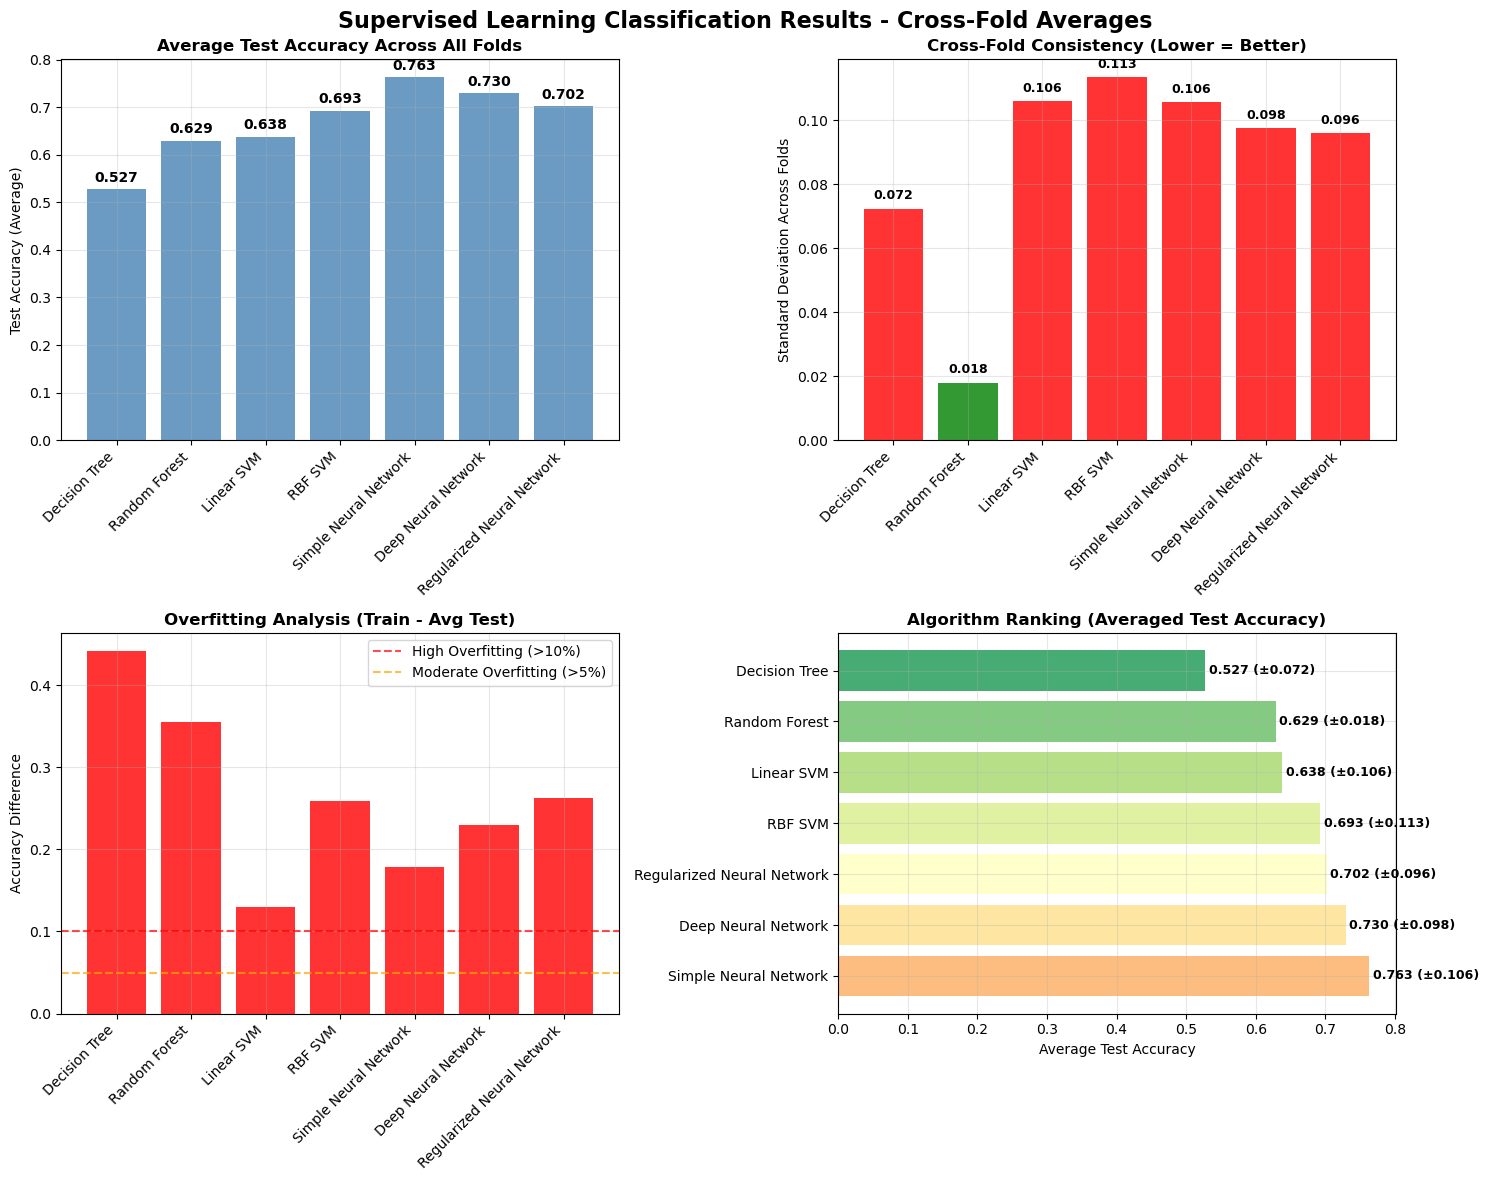


📋 DETAILED RESULTS TABLE - CROSS-FOLD AVERAGES
                 Algorithm Avg Test Accuracy Fold Std Dev Consistency Overfitting Generalization
     Simple Neural Network             0.763        0.106      ⚠️ Low       0.179        ⚠️ High
       Deep Neural Network             0.730        0.098      ⚠️ Low       0.230        ⚠️ High
Regularized Neural Network             0.702        0.096      ⚠️ Low       0.263        ⚠️ High
                   RBF SVM             0.693        0.113      ⚠️ Low       0.258        ⚠️ High
                Linear SVM             0.638        0.106      ⚠️ Low       0.130        ⚠️ High
             Random Forest             0.629        0.018      ✅ High       0.355        ⚠️ High
             Decision Tree             0.527        0.072      ⚠️ Low       0.442        ⚠️ High

📊 CROSS-FOLD SUMMARY STATISTICS
🎯 Best Algorithm: Simple Neural Network (0.763 ± 0.106)
📈 Average Test Accuracy: 0.669
📉 Worst Algorithm: Decision Tree (0.527 ± 0.072)
🔄 Accur

In [9]:
# ============================================================
# 📈 RESULTS VISUALIZATION AND ANALYSIS - CROSS-FOLD AVERAGES
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.supervised_classification import analyze_results_by_category

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

if ("supervised_classifier" in locals() and supervised_classifier is not None and 
    "fold_accuracies" in locals() and fold_accuracies):
    
    print("🎯 GENERATING COMPREHENSIVE VISUALIZATIONS - CROSS-FOLD AVERAGES")
    print("=" * 65)
    
    # ============================================================
    # EXTRACT AVERAGED FOLD RESULTS
    # ============================================================
    
    # Get model names from original results for consistency
    original_results = supervised_classifier.results
    model_names = [r['model_name'] for r in original_results]
    
    # Calculate averaged results across all folds
    fold_names = sorted(fold_accuracies.keys())
    averaged_results = []
    
    for model_name in model_names:
        # Get accuracies across all folds for this model
        fold_accs = [fold_accuracies[fold].get(model_name, 0.0) for fold in fold_names]
        avg_test_acc = np.mean(fold_accs) if fold_accs else 0.0
        
        # Find corresponding original result for train accuracy and time
        original_result = next((r for r in original_results if r['model_name'] == model_name), None)
        train_acc = original_result['train_accuracy'] if original_result else 0.0
        train_time = original_result['training_time'] if original_result else 0.0
        
        averaged_results.append({
            'model_name': model_name,
            'test_accuracy': avg_test_acc,
            'train_accuracy': train_acc,  # Note: this is from single fold
            'training_time': train_time,
            'fold_variance': np.std(fold_accs) if len(fold_accs) > 1 else 0.0
        })
    
    # Extract data for plotting - NOW USING CROSS-FOLD AVERAGES
    test_accuracies = [r['test_accuracy'] for r in averaged_results]
    train_accuracies = [r['train_accuracy'] for r in averaged_results]
    fold_variances = [r['fold_variance'] for r in averaged_results]
    
    print(f"📊 Using averaged results across {len(fold_names)} folds")
    print(f"   • Fold variance indicates consistency across different data splits")
    
    # ============================================================
    # 1. PERFORMANCE COMPARISON BAR CHART
    # ============================================================
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Supervised Learning Classification Results - Cross-Fold Averages', fontsize=16, fontweight='bold')
    
    # Bar chart of test accuracies (AVERAGED ACROSS FOLDS)
    bars1 = ax1.bar(range(len(model_names)), test_accuracies, alpha=0.8, color='steelblue')
    ax1.set_title('Average Test Accuracy Across All Folds', fontweight='bold')
    ax1.set_ylabel('Test Accuracy (Average)')
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars1, test_accuracies)):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # ============================================================
    # 2. FOLD CONSISTENCY ANALYSIS (VARIANCE)
    # ============================================================
    
    # Color by variance (low variance = green, high variance = red)
    colors_variance = ['green' if v < 0.02 else 'orange' if v < 0.05 else 'red' for v in fold_variances]
    
    bars2 = ax2.bar(range(len(model_names)), fold_variances, alpha=0.8, color=colors_variance)
    ax2.set_title('Cross-Fold Consistency (Lower = Better)', fontweight='bold')
    ax2.set_ylabel('Standard Deviation Across Folds')
    ax2.set_xticks(range(len(model_names)))
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, var) in enumerate(zip(bars2, fold_variances)):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.002,
                f'{var:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # ============================================================
    # 3. OVERFITTING ANALYSIS (Note: Train is from single fold)
    # ============================================================
    
    # Calculate overfitting (train - averaged test accuracy)
    overfitting = [train - test for train, test in zip(train_accuracies, test_accuracies)]
    colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green' for x in overfitting]
    
    bars4 = ax3.bar(range(len(model_names)), overfitting, alpha=0.8, color=colors)
    ax3.set_title('Overfitting Analysis (Train - Avg Test)', fontweight='bold')
    ax3.set_ylabel('Accuracy Difference')
    ax3.set_xticks(range(len(model_names)))
    ax3.set_xticklabels(model_names, rotation=45, ha='right')
    ax3.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='High Overfitting (>10%)')
    ax3.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Moderate Overfitting (>5%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # ============================================================
    # 4. ALGORITHM RANKING BY AVERAGED PERFORMANCE
    # ============================================================
    
    # Sort by averaged test accuracy
    sorted_results = sorted(zip(model_names, test_accuracies, fold_variances), key=lambda x: x[1], reverse=True)
    sorted_names, sorted_accs, sorted_vars = zip(*sorted_results)
    
    colors_ranking = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(sorted_names)))
    bars5 = ax4.barh(range(len(sorted_names)), sorted_accs, alpha=0.8, color=colors_ranking)
    ax4.set_title('Algorithm Ranking (Averaged Test Accuracy)', fontweight='bold')
    ax4.set_xlabel('Average Test Accuracy')
    ax4.set_yticks(range(len(sorted_names)))
    ax4.set_yticklabels(sorted_names)
    ax4.grid(True, alpha=0.3)
    
    # Add value labels with variance info
    for i, (bar, acc, var) in enumerate(zip(bars5, sorted_accs, sorted_vars)):
        ax4.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2.,
                f'{acc:.3f} (±{var:.3f})', ha='left', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # ============================================================
    # 5. DETAILED RESULTS TABLE - CROSS-FOLD AVERAGES
    # ============================================================
    
    print("\n📋 DETAILED RESULTS TABLE - CROSS-FOLD AVERAGES")
    print("=" * 70)
    
    # Create DataFrame for better visualization
    df_results = pd.DataFrame({
        'Algorithm': model_names,
        'Avg Test Accuracy': [f"{acc:.3f}" for acc in test_accuracies],
        'Fold Std Dev': [f"{var:.3f}" for var in fold_variances],
        'Consistency': ['✅ High' if var < 0.02 else '🔶 Medium' if var < 0.05 else '⚠️ Low' for var in fold_variances],
        'Overfitting': [f"{diff:.3f}" for diff in overfitting],
        'Generalization': ['⚠️ High' if diff > 0.1 else '🔶 Moderate' if diff > 0.05 else '✅ Good' for diff in overfitting]
    })
    
    # Sort by averaged test accuracy
    df_results = df_results.sort_values('Avg Test Accuracy', ascending=False)
    print(df_results.to_string(index=False))
    
    # ============================================================
    # 6. SUMMARY STATISTICS - CROSS-FOLD AVERAGES
    # ============================================================
    
    print(f"\n📊 CROSS-FOLD SUMMARY STATISTICS")
    print("=" * 40)
    print(f"🎯 Best Algorithm: {sorted_names[0]} ({sorted_accs[0]:.3f} ± {sorted_vars[0]:.3f})")
    print(f"📈 Average Test Accuracy: {np.mean(test_accuracies):.3f}")
    print(f"📉 Worst Algorithm: {sorted_names[-1]} ({sorted_accs[-1]:.3f} ± {sorted_vars[-1]:.3f})")
    print(f"🔄 Accuracy Range: {max(test_accuracies) - min(test_accuracies):.3f}")
    
    # Count consistency levels
    high_consistency = sum(1 for x in fold_variances if x < 0.02)
    medium_consistency = sum(1 for x in fold_variances if 0.02 <= x < 0.05)
    low_consistency = sum(1 for x in fold_variances if x >= 0.05)
    
    print(f"\n🔄 CROSS-FOLD CONSISTENCY ANALYSIS:")
    print(f"   ✅ High Consistency: {high_consistency}/{len(averaged_results)} algorithms")
    print(f"   🔶 Medium Consistency: {medium_consistency}/{len(averaged_results)} algorithms")
    print(f"   ⚠️ Low Consistency: {low_consistency}/{len(averaged_results)} algorithms")
    
    # Most consistent algorithm
    most_consistent = min(zip(model_names, fold_variances), key=lambda x: x[1])
    print(f"\n🏆 Most Consistent Algorithm: {most_consistent[0]} (std: {most_consistent[1]:.3f})")
    
    print(f"\n🎓 CROSS-FOLD LEARNING INSIGHTS:")
    print(f"   • Results averaged across {len(fold_names)} cross-validation folds")
    print(f"   • Consistency measured by standard deviation across folds")
    print(f"   • Best algorithm combines high accuracy with low variance")
    print(f"   • Classes analyzed: {selected_classes}")
    
    print(f"\n✅ Cross-fold visualization complete! Robust performance estimates ready.")

else:
    print("❌ No cross-fold results available.")
    print("💡 Please run all the previous cells first:")
    print("   1. Data loading and configuration")
    print("   2. Model training and validation")
    print("   3. Cross-fold validation analysis")
    print("\nThen re-run this cell to see cross-fold averaged visualizations.")

## Results Visualization Implementation

**Visualization strategy:**
1. **Performance comparison** - Bar charts for clear algorithm ranking
2. **Overfitting analysis** - Visual assessment of generalization quality
3. **Statistical summary** - Comprehensive performance metrics
4. **Category analysis** - Strengths of different algorithm families

**Interpretation guidelines:**
- **Green overfitting bars** - Good generalization (≤5% gap)
- **Orange bars** - Moderate overfitting (5-10% gap)
- **Red bars** - High overfitting (>10% gap)
- **Consistent cross-fold performance** - Reliable algorithm
- **High variance across folds** - Unstable algorithm

**Actionable insights:**
- **Best algorithm selection** - For production deployment
- **Architecture optimization** - Which complexity level works best
- **Feature engineering needs** - Based on algorithm performance patterns